# Read Geometry from PostGIS

In [1]:
library(plyr)
library(pryr)
library(ggplot2)
library(grid)
library(gridExtra)
library(rgdal)
library(raster)
library(rgeos)
library(tools) 
library(sf)
library(tidyverse)
library(rsconnect)
library(JuliaCall)
library(rpostgis)
library(leaflet)

options(warn=-1)

Registered S3 method overwritten by 'pryr':
  method      from
  print.bytes Rcpp

Loading required package: sp

rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.4, released 2020/10/20
Path to GDAL shared files: /Users/work/Library/R/4.0/library/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: /Users/work/Library/R/4.0/library/rgdal/proj
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.


Attaching package: ‘raster’


The following object is masked from ‘package:pryr’:

    subs


rgeos version: 0.5-5, (SVN revision 640)
 GEOS runtime version: 3.8.1-CAPI-1.13.3 
 Linking to sp version: 1.4-2 
 Polygon checking: TRUE 


Linking to GEOS 3.8.1, GDAL 3.1.4, PROJ 6.3.1

── Attachi

# Setup

In [2]:
roost = c(274257,66207)
radius = 300
resolution = 1

xmax = roost[1]+radius
ymax = roost[2]+radius
xmin = roost[1]-radius
ymin = roost[2]-radius

ext <- extent(xmin,xmax,ymin,ymax)
ext

class      : Extent 
xmin       : 273957 
xmax       : 274557 
ymin       : 65907 
ymax       : 66507 

# Ground Raster

In [3]:
ground_rast <- function(roost, radius, resolution) {
  #Generates a ground raster: NA everywhere except roost coordinates, used for resampling
  groundrast <- raster(
        xmn= roost[1] - radius,   # set minimum x coordinate
        xmx = roost[1] + radius,    # set maximum x coordinate
        ymn = roost[2] - radius,     # set minimum y coordinate
        ymx = roost[2] + radius,     # set maximum y coordinate
        res = c(resolution,resolution),
        crs = NA
    ) 
  roosts <- matrix(c(roost[1],roost[2]), nrow = 1, ncol = 2)
  groundrast <- rasterize(roosts,groundrast)
  return(groundrast)
}

In [4]:
groundrast <- ground_rast(roost, radius, resolution)
writeRaster(groundrast, "circuitscape/ground.asc", overwrite=TRUE)
groundrast

class      : RasterLayer 
dimensions : 600, 600, 360000  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : 273957, 274557, 65907, 66507  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : memory
names      : layer 
values     : 1, 1  (min, max)


# Query OS Vector Data

In [5]:
build_query_string <- function(tableName, ext) {
    xmin = attr(ext, "xmin")
    xmax = attr(ext, "xmax")
    ymin = attr(ext, "ymin")
    ymax = attr(ext, "ymax")
    envelope_params <- paste(xmin, ymin, xmax, ymax, 27700, sep=",")
    envelope <- paste("ST_MakeEnvelope(", envelope_params, ")")
    clip <- paste("ST_Intersection(", tableName, ".geom, ", envelope, ")", sep="")
    multi <- paste("ST_Multi(", clip, ") AS geom")
    query <- paste("SELECT ", multi, " FROM ", tableName, " WHERE ", tableName, ".geom && ", envelope, ";")
    return(query)
}

In [6]:
read_db_vector <- function(tableName, ext) {
    driver <- dbDriver("PostgreSQL")
    connection <- dbConnect(driver, dbname="os", port=5433)
    query = build_query_string(tableName, ext)
    results_sf <- pgGetGeom(connection, query=query)
    dbDisconnect(connection)
    return(results_sf)
}

## Roads

Returning MultiLineString types in SpatialLines*-class.



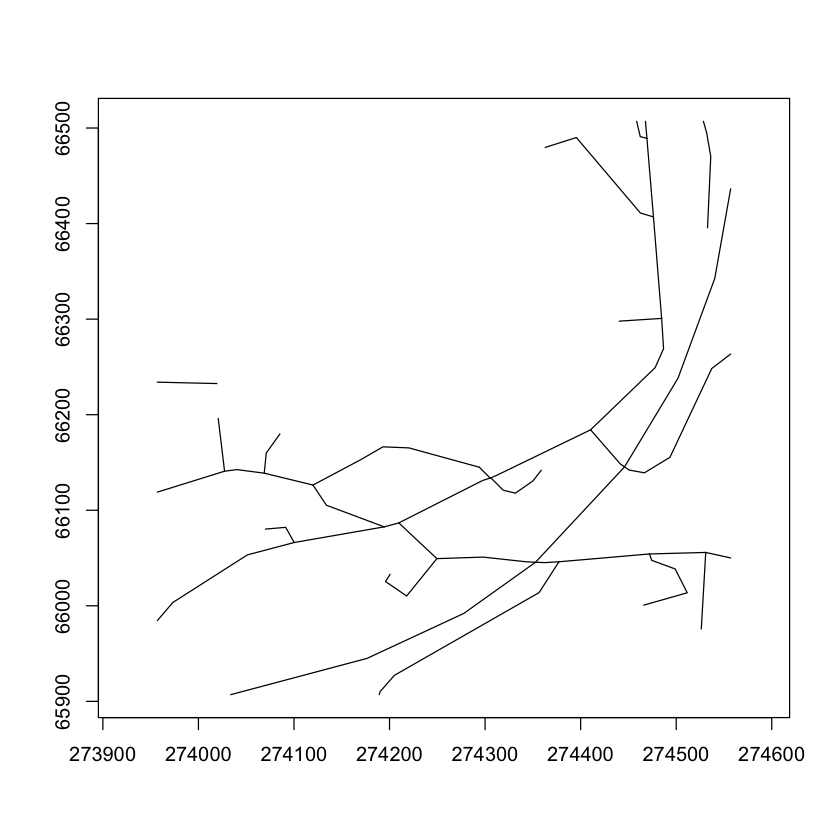

In [7]:
roads <- read_db_vector("roads", ext)
plot(roads, axes=TRUE)

## Rivers

Returning MultiLineString types in SpatialLines*-class.



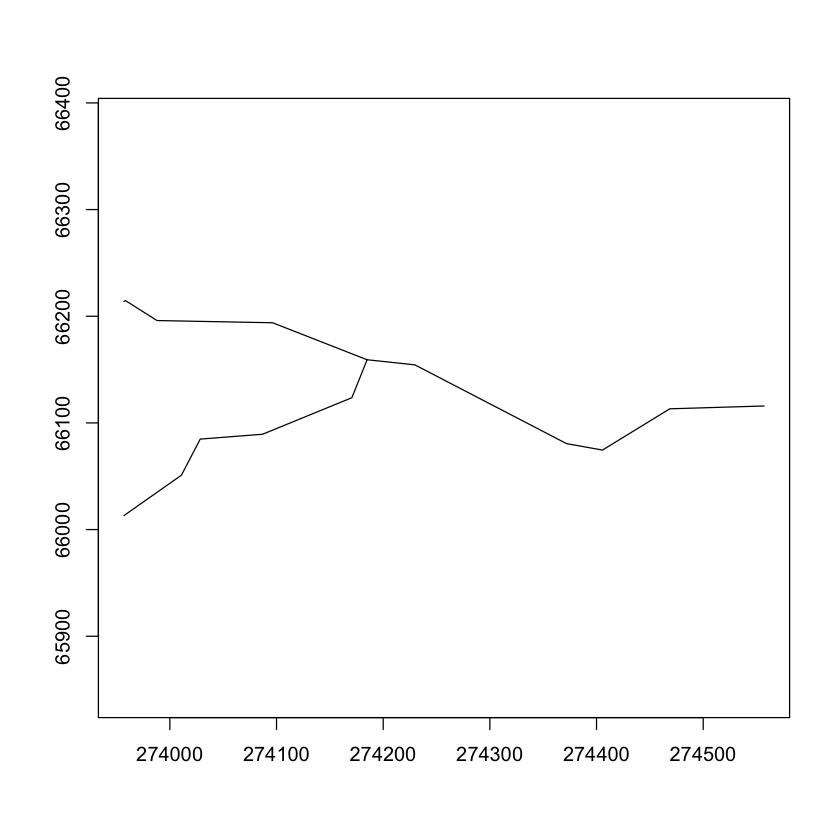

In [8]:
rivers <- read_db_vector("rivers", ext)
plot(rivers, axes=TRUE)

## Buildings

Returning MultiPolygon types in SpatialPolygons*-class.



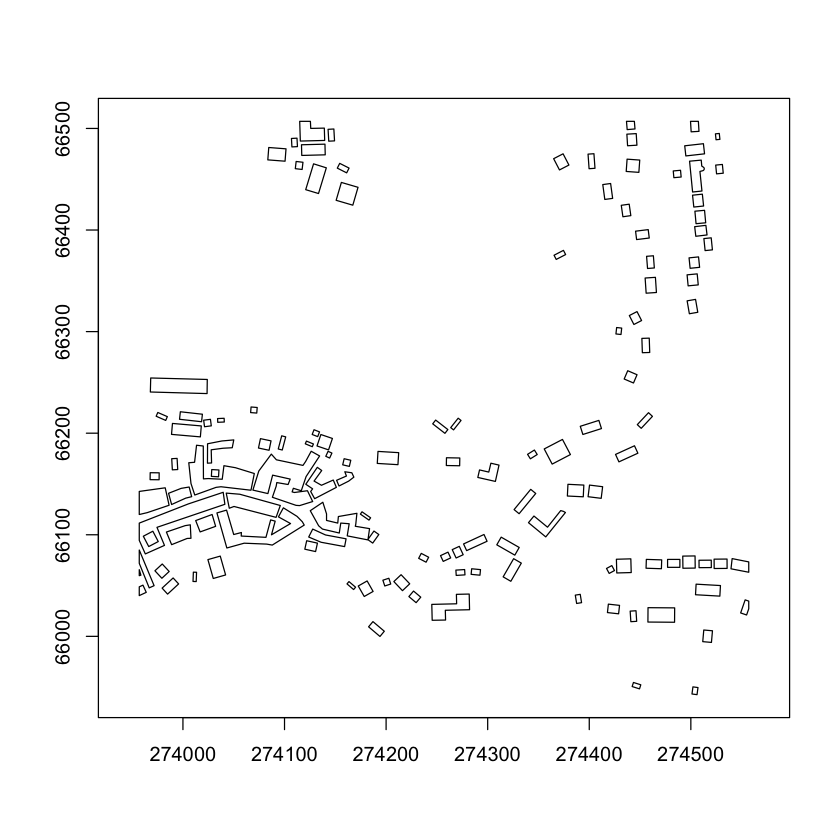

In [9]:
buildings <- read_db_vector("buildings", ext)
plot(buildings, axes=TRUE)

### Rasterize Vector Buildings

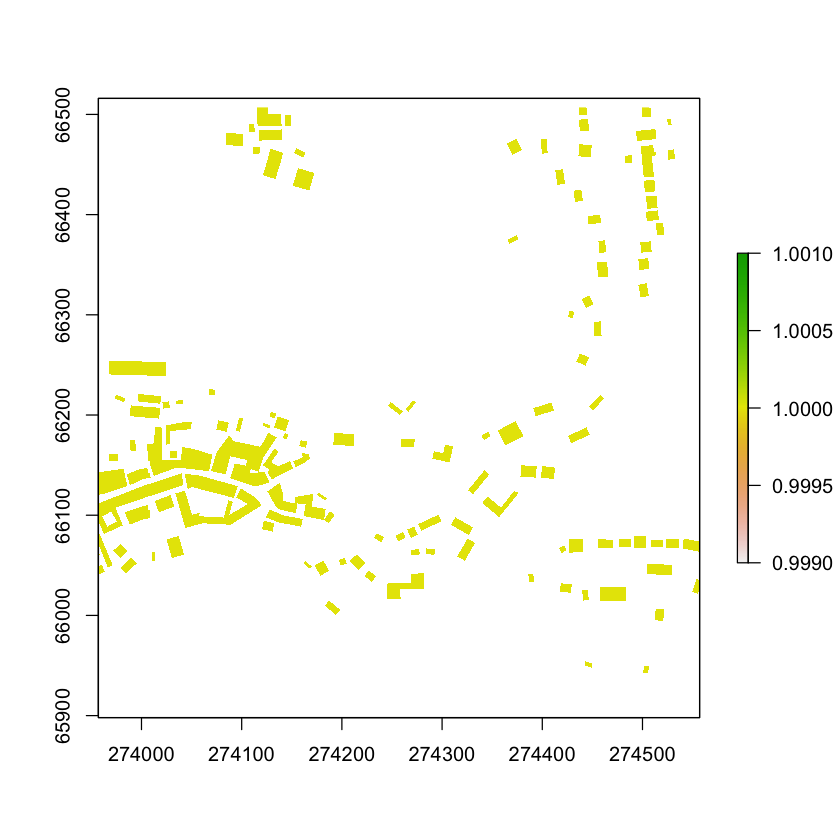

In [10]:
buildings <- rasterize(buildings, groundrast)
buildings[!is.na(buildings)] <- 1
plot(buildings, axes=TRUE)

# Resistance

## Road Resistance

In [11]:
roadResistance <- function(roads, groundrast) { 
    buffer <- 200   # meters to road
    Resmax <- c(10) # max resistance of layers
    Xmax <- c(5)    # x is the slope value
    Rbuff <- 0
    r <- rasterize(roads, groundrast)
    roadDistance <- distance(r)
    resistance <- round(calc(roadDistance, function(Distance) {ifelse(Distance > buffer, Rbuff, (((1 - (Distance/buffer))*0.5 + 0.5)^Xmax)*Resmax)})+1, digits=3)
    return(resistance)
}

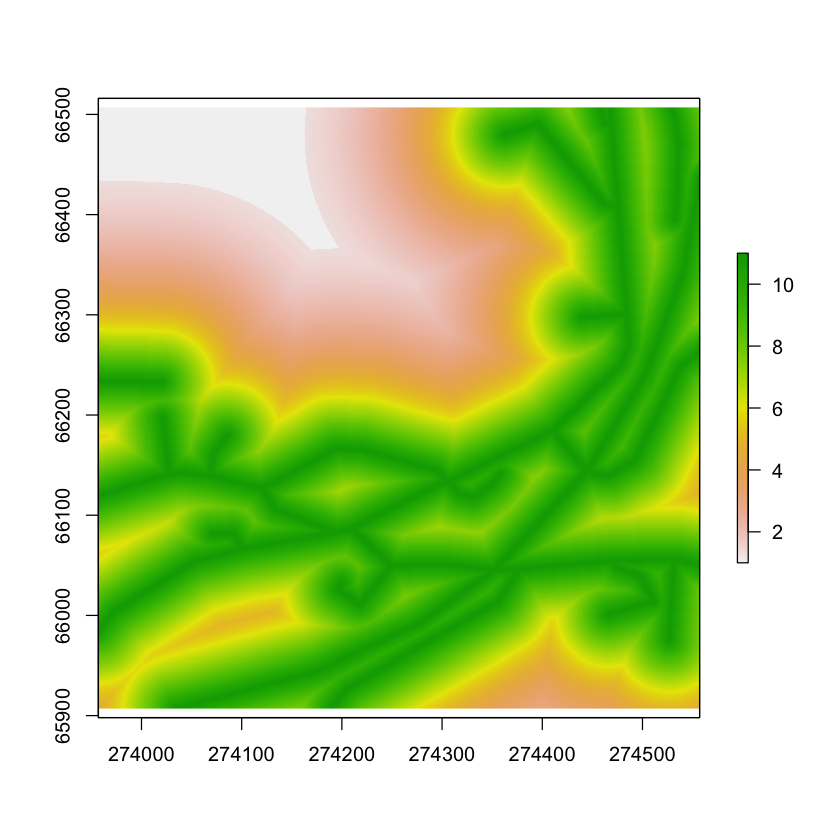

In [12]:
roadRes <- roadResistance(roads, groundrast)
writeRaster(roadRes, "images/roadRes.tiff", "GTiff", overwrite=TRUE)
plot(roadRes)

## River Resistance

In [13]:
riverResistance <- function(river) {  
    buffer <- 10
    Rankmax <- 1
    Resmax <- c(2000)
    Xmax <- c(4)
    Rbuff = Resmax
    r <- rasterize(river,groundrast)
    riverDistance <- distance(r)
    riverDistance[is.na(riverDistance)] <- 0
    resistance <- round(calc(riverDistance, function(Distance) {ifelse(Distance > buffer, Rbuff, ((Distance/buffer)^Xmax)*Resmax)})+1, digits=3) #this is the function: distance/ranks in traffic 
    resistance[is.na(resistance)] <- 1
    return(resistance)
}

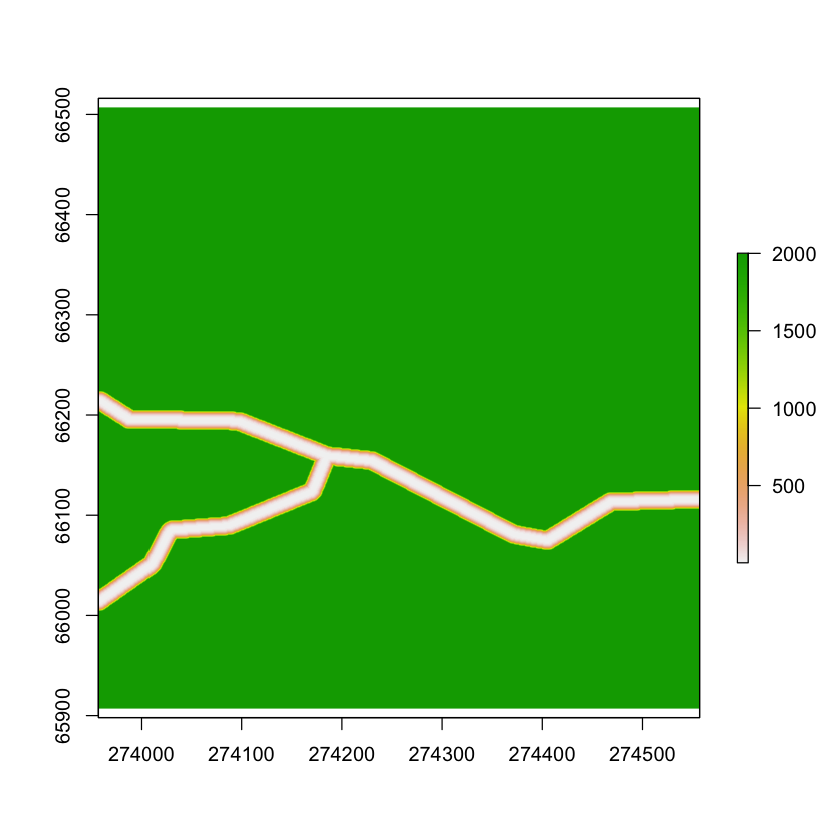

In [14]:
riverRes = riverResistance(rivers)
writeRaster(riverRes, "images/riverRes", "GTiff", overwrite=TRUE)
plot(riverRes)

# Query LIDAR Raster Data

In [15]:
create_raster_query_boundary <- function(ext) {
    xmin = attr(ext, "xmin")
    xmax = attr(ext, "xmax")
    ymin = attr(ext, "ymin")
    ymax = attr(ext, "ymax")
    boundary = c(ymax, ymin, xmax, xmin)
    return(boundary)
}

In [16]:
read_db_raster <- function(table, ext) {
    name = c("public", table)
    boundary = create_raster_query_boundary(ext)
    driver <- dbDriver("PostgreSQL")
    connection <- dbConnect(driver, dbname="os", port=5433)
    raster <- pgGetRast(connection, name=name, boundary=boundary)
    dbDisconnect(connection)
    return(raster)
}

## DSM

In [17]:
dsm = read_db_raster("dsm", ext)
typeof(dsm)

[1] "S4"

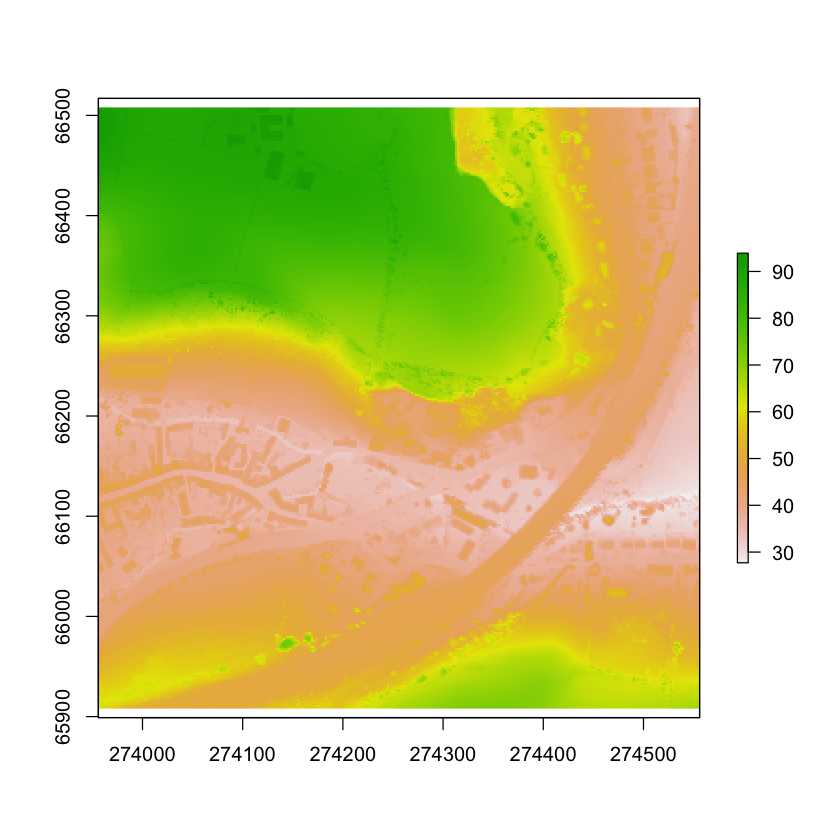

In [18]:
writeRaster(dsm, "images/dsm", "GTiff", overwrite=TRUE)
plot(dsm, axes=TRUE)

## DTM

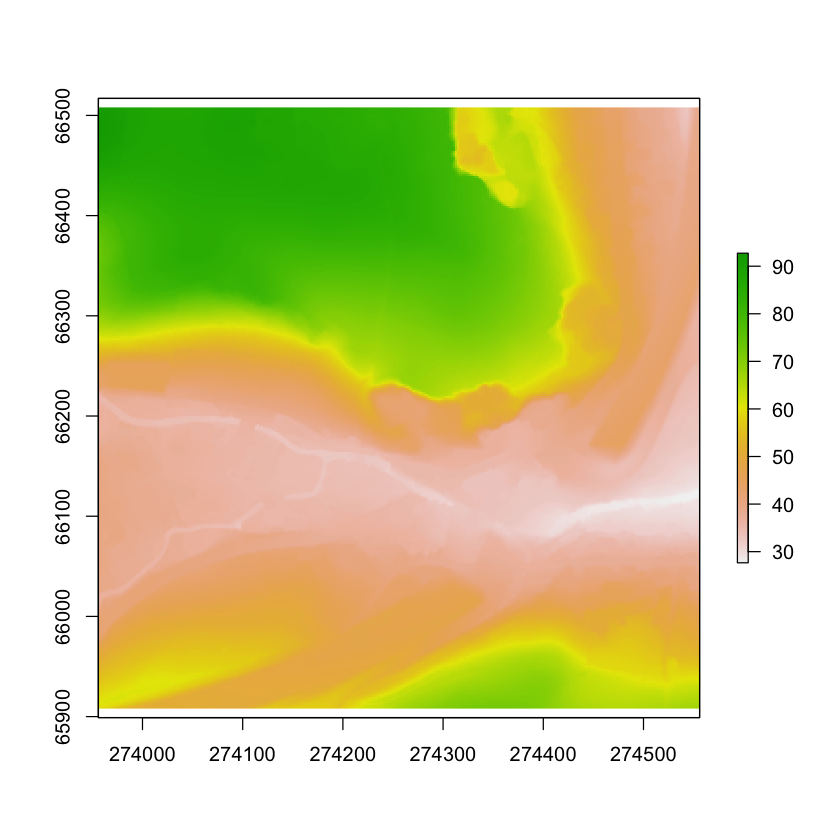

In [19]:
dtm = read_db_raster("dtm", ext)
writeRaster(dtm, "images/dtm", "GTiff", overwrite=TRUE)
plot(dtm, axes=TRUE)

# Landcover Resistance

## Resample LIDAR rasters

In [20]:
print(dim(buildings))

[1] 600 600   1


In [21]:
print(dim(dtm))
r_dtm = resample(dtm, groundrast)
print(dim(r_dtm))

[1] 300 300   1
[1] 600 600   1


In [22]:
print(dim(dsm))
r_dsm = resample(dsm, groundrast)
print(dim(r_dsm))

[1] 300 300   1
[1] 600 600   1


## Surfaces

In [23]:
calc_surfs <- function(dtm, dsm, buildings){
    ### Returns surf, soft and hard surface rasters
    surf <- dsm - dtm

    soft_surf <- (buildings+1)*surf
    soft_surf[is.na(soft_surf)] <- 0
    soft_surf <- surf - soft_surf

    hard_surf <- buildings
    hard_surf[is.na(hard_surf)] <- 1
    hard_surf<- hard_surf * surf
    hard_surf <- abs(hard_surf - surf)
    return(c("surf"=surf, "soft_surf"=soft_surf, "hard_surf"=hard_surf))
}

In [24]:
surfs <- calc_surfs(r_dtm, r_dsm, buildings)
surfs

$surf
class      : RasterLayer 
dimensions : 600, 600, 360000  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : 273957, 274557, 65907, 66507  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : memory
names      : layer 
values     : -1.452815, 22.65187  (min, max)


$soft_surf
class      : RasterLayer 
dimensions : 600, 600, 360000  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : 273957, 274557, 65907, 66507  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : memory
names      : layer 
values     : -11.87956, 22.65187  (min, max)


$hard_surf
class      : RasterLayer 
dimensions : 600, 600, 360000  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : 273957, 274557, 65907, 66507  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : memory
names      : layer 
values     : 0, 0  (min, max)



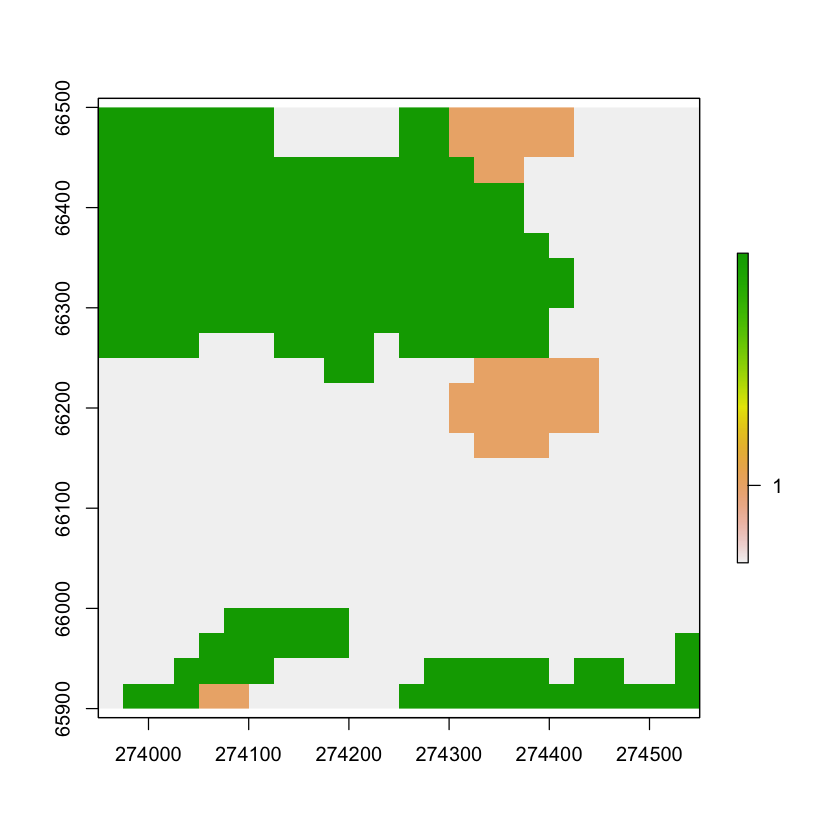

In [25]:
lcm = read_db_raster("lcm", ext)
writeRaster(lcm, "images/lcm", "GTiff", overwrite=TRUE)
plot(lcm, axis=TRUE)

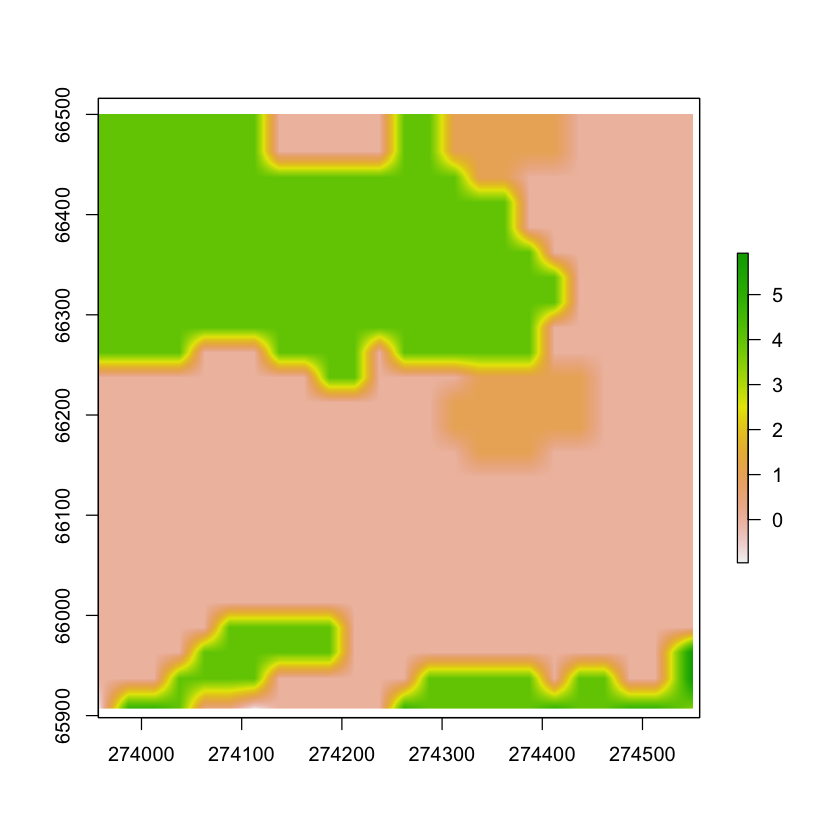

In [26]:
lcm_r <- resample(lcm, groundrast)
writeRaster(lcm_r, "images/lcm_r", "GTiff", overwrite=TRUE)
plot(lcm_r)

In [27]:
filter_binary_layer <- function(value) {
    fn <- function(x, y) {
        ifelse(y==1, value, x)
    }
    return(fn)
}

ranked_resistance <- function(conductance, Rankmax, Resmax, Xmax) {
    resistance <- calc(conductance, fun=function(rank) {ifelse(rank == Rankmax, Resmax, (rank/Rankmax)^Xmax * Resmax)})
    resistance <- resistance + 1
    resistance <- round(resistance, digits = 3)
    resistance[is.na(resistance) == TRUE] <- 1
    return(resistance)
}

landscapeResistance_lcm <- function(lcm, buildings, soft_surf) {
    lidar_ranking <- c(-Inf, 0.5, 4,  # grass
                        0.5, 2.5, 3,  # scrub
                        2.5, Inf, 3)  # trees
    Resmax <- 100
    Xmax <- 5
    surfs$soft_surf[is.na(surfs$soft_surf)] <- 0
    conductance <- reclassify(surfs$soft_surf, lidar_ranking) + lcm
    Ranking <- maxValue(conductance)+1 #Max ranking: makes buildings the highest resistance
    rast <- buildings
    rast[!is.na(rast==TRUE)] <- 1.0 ## features
    rast[is.na(rast==TRUE)] <- 0.0  ## no features
    conductance <- overlay(conductance, rast, fun=filter_binary_layer(Ranking))
#     resistance <- ranked_resistance(conductance, Rankmax, Resmax, Xmax)
}

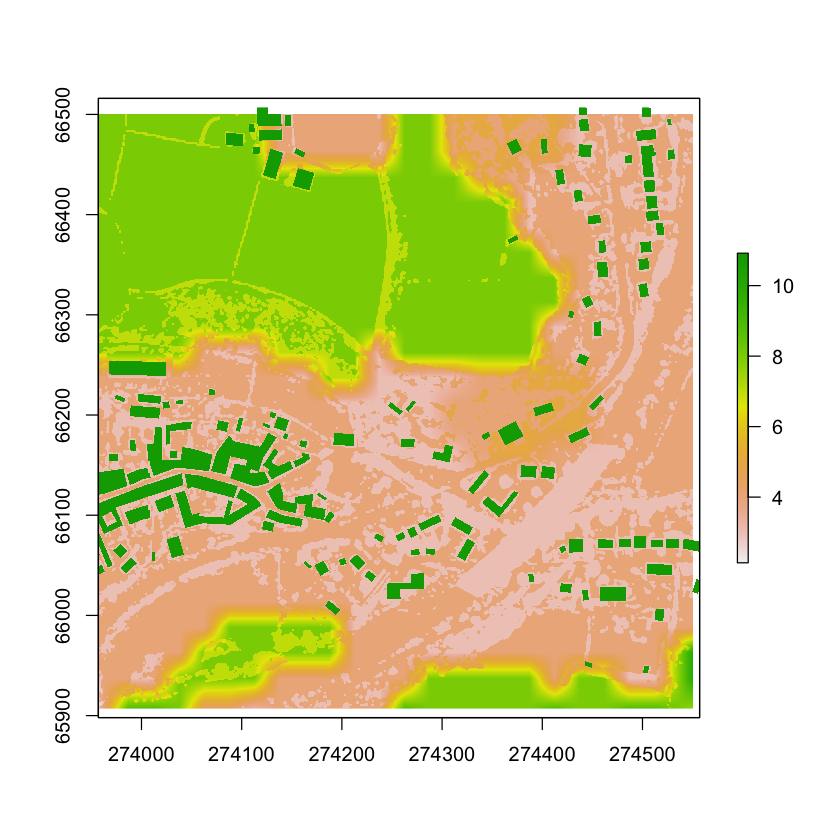

In [28]:
landscapeRes = landscapeResistance_lcm(lcm_r, buildings, surfs$soft_surf)
writeRaster(landscapeRes, "images/landscapeRes", "GTiff", overwrite=TRUE)
plot(landscapeRes)

Linear features: hedgerows and trees. Resistance is based on distance from the nearest feature.

In [29]:
prep_lidar_tifs <- function(surf, output_dir) { 
  #' Generates new rasters containing locations of:
  #' - manhedge.asc: managed hedgerows (height = 1m-3m above ground)
  #' - unmanhedge.asc: unmanaged hedgerows (height = 3m-6m above ground)
  #' - tree.asc: trees (height = 6m+ above ground)
  #' Add a buffer around all features of width 10m
  #' Then calculate the distance in each cell to the nearest feature
  #' Distance raster files are saved in directory output_dir
  
  manhedge <- surf
  manhedge[surf<3 & surf>1] <- 1
  manhedge[surf>=3] <- NA
  manhedge[surf<=1] <- NA
  manhedge <- buffer(manhedge, width=10, filename=paste(output_dir, "manhedge.asc",sep="/"), overwrite=TRUE)
  
  unmanhedge <- surf
  unmanhedge[surf<6 & surf>3] <- 1
  unmanhedge[surf>=6] <- NA
  unmanhedge[surf<=3] <- NA
  unmanhedge <- buffer(unmanhedge, width=10, filename=paste(output_dir, "umanhedge.asc",sep="/"), overwrite=TRUE)
  
  tree <- surf
  tree[surf>=6] <- 1
  tree[surf<6] <- NA
  tree <- buffer(tree,width=10, filename=paste(output_dir, "tree.asc",sep="/"), overwrite=TRUE)
  
  distance_rasters <- matrix(c(distance(unmanhedge),1,distance(tree),2,distance(manhedge),4),nrow=3,ncol=2)
  return(distance_rasters)
}

distance_resistance <- function(buffer, Rankmax, Rbuff, Resmax, Xmax, distance_rasters, effect) { 
  #' Calculates resistance raster given a distance raster
  raster_resistance <- distance_rasters[[1,1]]
  values(raster_resistance) <- 0
  for (i in nrow(distance_rasters)) {
    rast <- distance_rasters[[i,1]]
    Ranking <- distance_rasters[[i,2]]
    rast[is.na(rast) == TRUE] <- 0
    if (effect == "negative") {
      partial_resistance <- round(calc(rast, function(Distance) {ifelse(Distance > buffer, Rbuff, (((1 - (Distance/buffer))*0.5 + 0.5 *(Ranking/Rankmax))^Xmax)*Resmax)})+1, digits=3) #this is the function: distance/ranks in traffic 
    }
    else {
      partial_resistance <- round(calc(rast, function(Distance) {ifelse(Distance > buffer, Rbuff, ((((Distance/buffer))*0.5 + 0.5 *(Ranking/Rankmax))^Xmax)*Resmax)})+1, digits=3) #this is the function: distance/ranks in traffic 
    }
    raster_resistance <- overlay(partial_resistance, raster_resistance, fun = max)  
  }
  raster_resistance[is.na(raster_resistance) == TRUE] <- 1
  raster_resistance
}


linearResistance <- function(surf, output_dir) { 
  distance_rasters <- prep_lidar_tifs(surf, output_dir)
  buffer <- 10
  Rankmax <- 4
  Resmax <- c(22000)
  Xmax <- c(3)
  Rbuff <- Resmax[1]
  resistance <- distance_resistance(buffer, Rankmax, Rbuff, Resmax, Xmax, distance_rasters, "positive")
  resistance
}

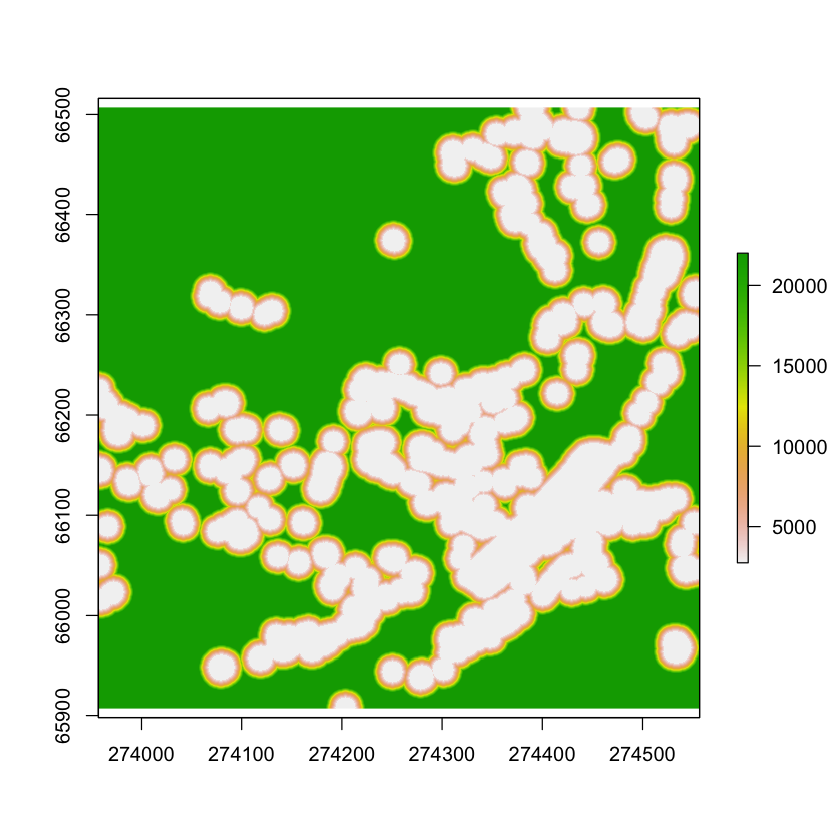

In [30]:
linearRes = linearResistance(surfs$soft_surf, "./images")
writeRaster(linearRes, "images/linearRes", "GTiff", overwrite=TRUE)
plot(linearRes)

Lights resistance: point irradiance calculated using the method from here: https://besjournals.onlinelibrary.wiley.com/doi/pdfdirect/10.1111/2041-210X.12182, the code is from the supplementary material.

In [31]:
lampResistance <- function(lamps, soft_surf, hard_surf, dtm){
  ext <- 100
  Resmax <- c(1e8)
  Xmax <- c(1)
  point_irradiance <- calc_point_irradiance(lamps,soft_surf,hard_surf,dtm)
  outputfile <- "images/light_resistance.asc"
  resistance <- light_resistance(Resmax, Xmax, point_irradiance, outputfile ,extent_file)
  return(resistance)
}


lightdist <- function(xdist,ydist,zdist,theta=NULL) {
  xyzdist <- sqrt(xdist^2+ydist^2+zdist^2)
  return(1/(xyzdist^2))
}

calc_point_irradiance<- function(lamps, soft_surf, hard_surf, terrain) {
  point_irradiance <- soft_surf
  values(point_irradiance) <- 0 
  ext <- 100
  sensor_ht <- 2.5
  absorbance <- 0.5  
  for(lamp in 1:dim(lamps)[1]) {
    
    x <- lamps$x[lamp]
    y <- lamps$y[lamp]
    z <- lamps$z[lamp]
    
    ### find dimensions of area of influence of light
    row <- rowFromY(hard_surf,min(max(y,ymin(hard_surf)),ymax(hard_surf)))
    col <- colFromX(hard_surf,max(min(x,xmax(hard_surf)),xmin(hard_surf)))
    col_min <- max(col-ext,1)
    col_max <- min(col+ext,colFromX(hard_surf,xmax(hard_surf)))
    col_lamp <- col-col_min
    row_min <- max(row-ext,1)
    row_max <- min(row+ext,rowFromY(hard_surf,ymin(hard_surf)))
    row_lamp <- row-row_min
    nrows <- row_max-row_min
    ncols <- col_max-col_min
    
    ### extract terrain data for area of influence of light 
    hard_block <- array(getValuesBlock(hard_surf,row=row_min,nrows=nrows,col=col_min,ncols=ncols),c(nrows,ncols))
    soft_block <- array(getValuesBlock(soft_surf,row=row_min,nrows=nrows,col=col_min,ncols=ncols),c(nrows,ncols))
    terrain_block <- array(getValuesBlock(terrain,row=row_min,nrows=nrows,col=col_min,ncols=ncols),c(nrows,ncols))
    hard_block[is.na(hard_block==TRUE)] <- 0
    soft_block[is.na(soft_block==TRUE)] <- 0
    terrain_block[is.na(terrain_block==TRUE)] <- 0
    point_irrad <- array(0,c(ncols,nrows))
    ### find values for irradiance on a horizontal plane and sphere
    if (ncols==200&nrows==200) {
      for(xx in 1:ncols) {
        for (yy in 1:nrows) {
          xdist <- col_lamp-xx
          ydist <- row_lamp-yy
          xydist <- sqrt(xdist^2+ydist^2)
          zdist <- (terrain_block[row_lamp,col_lamp]+z)-(terrain_block[yy,xx]+sensor_ht)
          xyzdist <- sqrt(xydist^2+zdist^2)
          dist <- floor(xydist+0.5)
          if (xydist<=ext && zdist>0 && is.na(hard_block[yy,xx])==FALSE && dist>0) {
            shadow <- 1
            shading <- 0
            for (d in 1:dist) {
              if(hard_block[as.integer(yy+(ydist)*(d/dist)),as.integer(xx+(xdist)*(d/dist))] >= (terrain_block[yy,xx]+sensor_ht+(d/dist)*zdist)) {
                shadow <- 0
                break
              }
              if(soft_block[as.integer(yy+(ydist)*(d/dist)),as.integer(xx+(xdist)*(d/dist))] >= (terrain_block[yy,xx]+sensor_ht+(d/dist)*zdist)) {
                shading <- shading + xyzdist/xydist
              }
              point_irrad[xx,yy] <- (1/(10^(absorbance*shading)))*shadow*lightdist(xdist,ydist,zdist)
            }
          }
        }
      }
      point_values <- raster(point_irrad,xmn=xFromCol(point_irradiance,col_min),ymn=yFromRow(point_irradiance,row_max),xmx=xFromCol(point_irradiance,col_max),ymx=yFromRow(point_irradiance,row_min))
      origin(point_values) <- origin(point_irradiance)
      point_irradiance <- mosaic(point_irradiance,point_values,fun=sum)
      removeTmpFiles()
    }
  }
  writeRaster(point_irradiance,filename=paste("images/point_irradiance.tif"),overwrite=TRUE)
  return(point_irradiance)
}

light_resistance <- function(Resmax, Xmax, rast, outputfile, extent_file) {
  print(Resmax)
  rast[is.na(rast==TRUE)] <- 0
  MaxPI <- maxValue(rast)
  raster_resistance <- round(calc(rast, fun=function(PI) {((PI/MaxPI)^Xmax)*Resmax}) + 1, digits = 3)
  raster_resistance[is.na(raster_resistance) == TRUE] <- 1
  writeRaster(raster_resistance, filename=outputfile, NAflag=-9999, overwrite=TRUE)
  raster_resistance
}

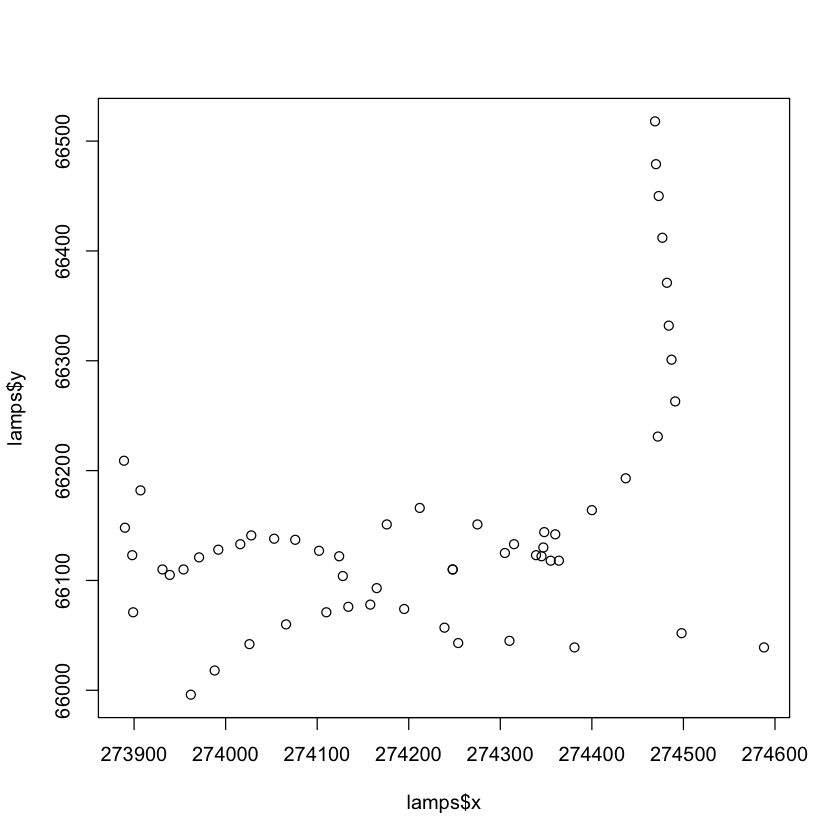

In [32]:
lamps <- read.csv(file="gis-layers/lights.csv", col.names=c("x","y","z"))
colnames(lamps) <- c("x","y","z")
ext <- 100
lamps <- lamps[(lamps$x-roost[1])^2 + (lamps$y-roost[2])^2 < (radius+ext)^2,]
plot(lamps$x,lamps$y)

In [33]:
png("images/lamps.png")
plot(lamps$x,lamps$y)
dev.off()

pdf 
  2

[1] 1e+08


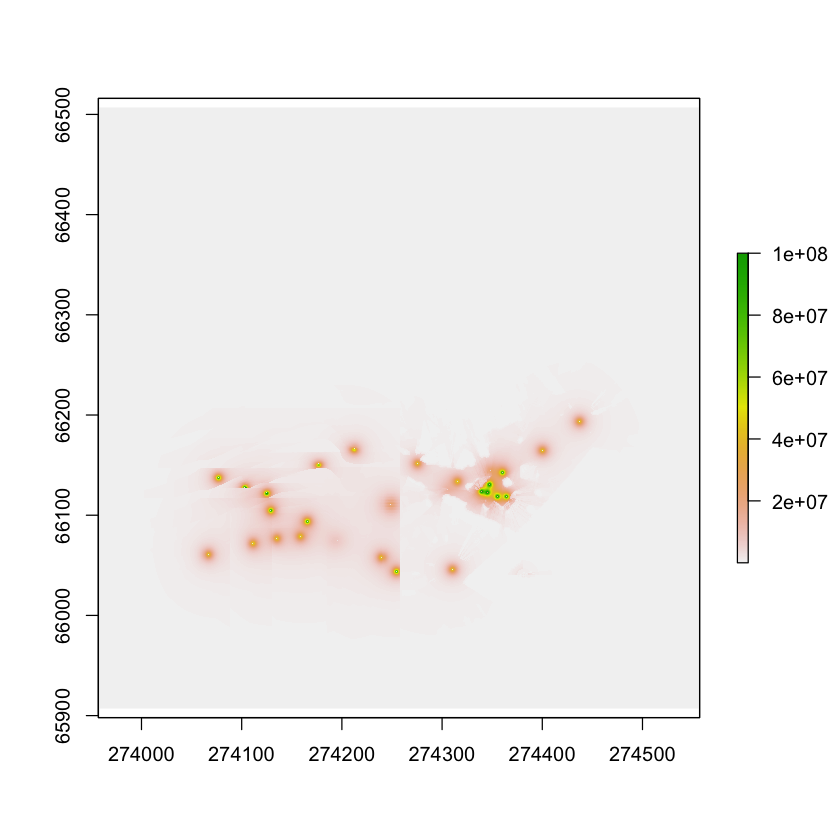

In [34]:
lampRes <- lampResistance(lamps,surfs$soft_surf,surfs$hard_surf,dtm)
writeRaster(lampRes, "images/lampRes", "GTiff", overwrite=TRUE)
plot(lampRes)

# Circuitscape

Prepare inputs to circuitscape: ground raster, source raster, resistance raster. Total resistance is the sum of individual resistances.

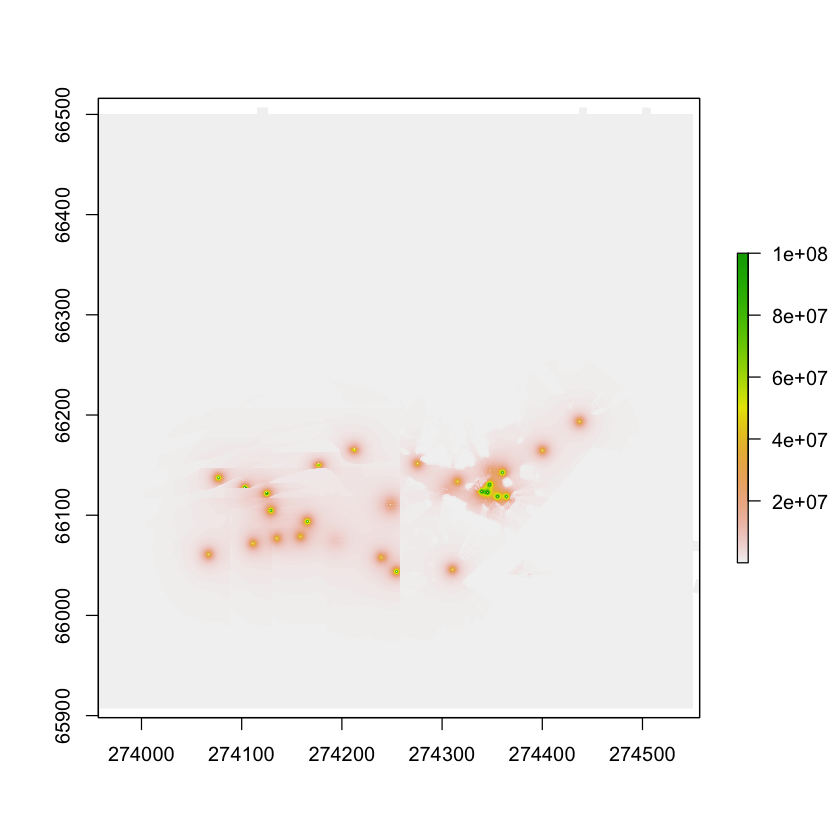

In [35]:
totalRes = lampRes+roadRes+linearRes+riverRes+landscapeRes
writeRaster(totalRes, "circuitscape/resistance.asc", overwrite=TRUE)
writeRaster(totalRes, "images/totalRes", "GTiff", overwrite=TRUE)
plot(totalRes)

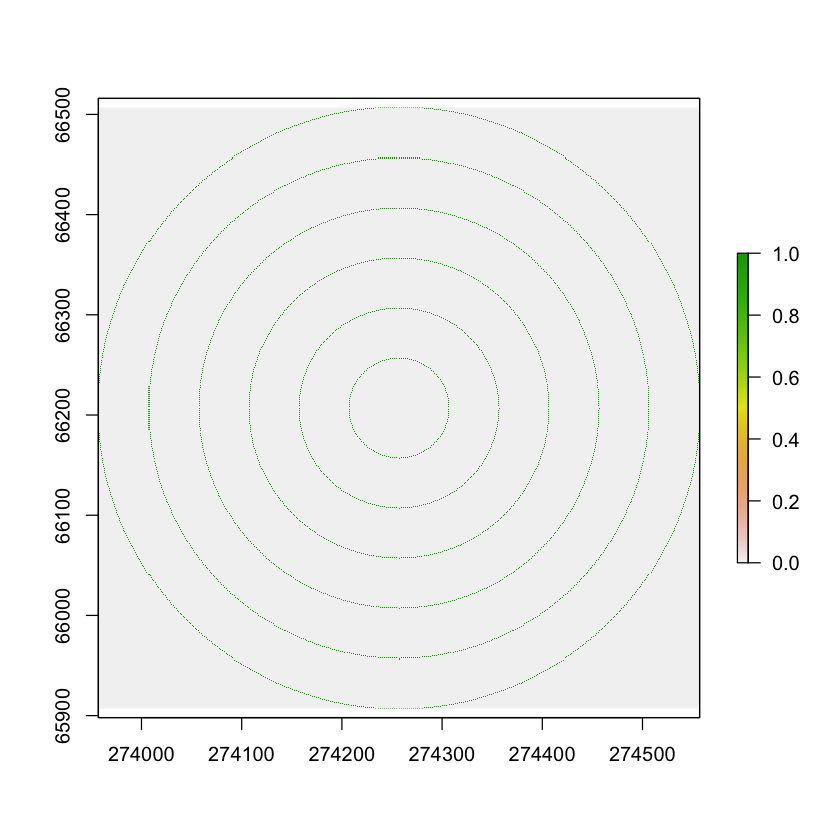

In [36]:
circles = groundrast
values(circles) = 0

for (r in seq(50,radius,50)) {
    angle = 2*pi*(0:(3*r))/(3*r)
    df <- data.frame( x = roost[1]+r*sin(angle), y = roost[2]+r*cos(angle))
    points = SpatialPoints(df, proj4string=CRS(as.character(NA)), bbox = NULL) 
    circles = circles + rasterize(points, groundrast,background=0)
}

circles[circles>0]=1
writeRaster(circles, "circuitscape/source.asc", NAflag=-9999, overwrite=TRUE)
plot(circles)

In [37]:
julia_install_package_if_needed("Circuitscape") # if you don't already have the package installed
julia_library("Circuitscape")                   # make sure Circuitscape is available
julia_call("compute", "cs.ini", need_return="None")

Julia version 1.5.3 at location /Applications/Julia-1.5.app/Contents/Resources/julia/bin will be used.

Loading setup script for JuliaCall...

Finish loading setup script for JuliaCall.



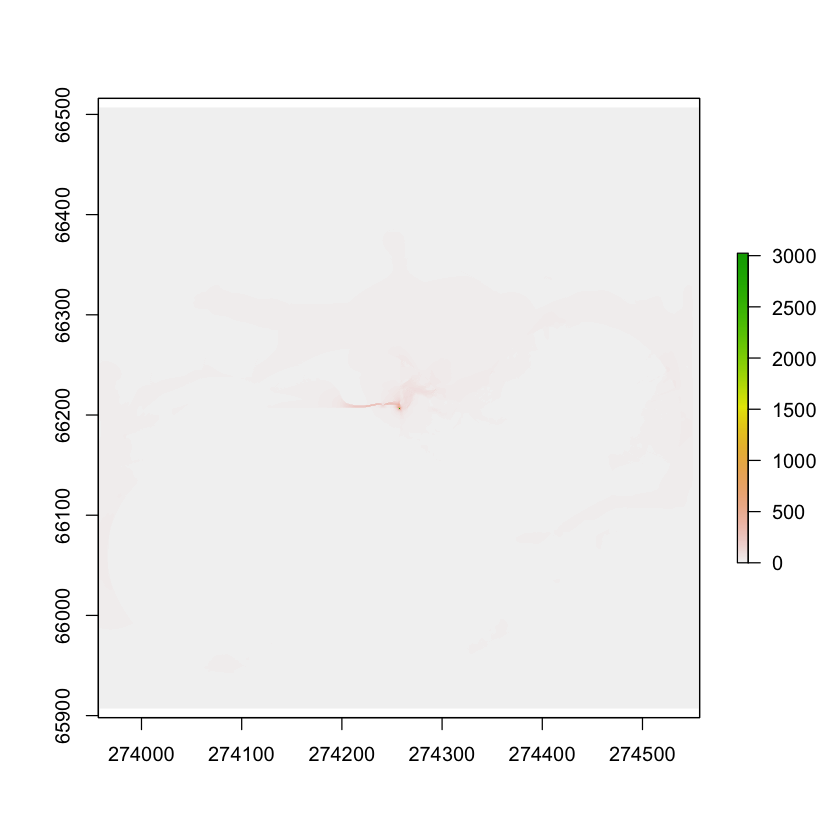

In [38]:
current = raster("cs_out_curmap.asc")
writeRaster(current, "images/current", "GTiff", options="INTERLEAVE=BAND", overwrite=TRUE)
plot(current)

In [39]:
png("images/current.png")
plot(current)
dev.off()

pdf 
  2

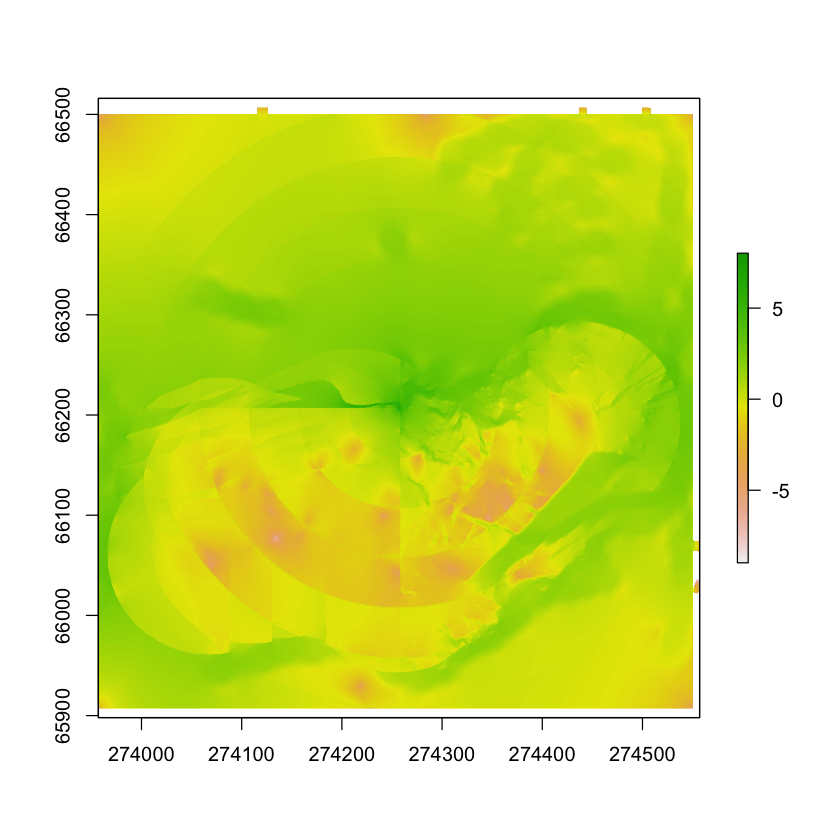

In [40]:
logCurrent = log(current)
plot(logCurrent)

In [41]:
png("images/logCurrent.png")
plot(logCurrent)
dev.off()

pdf 
  2

In [44]:
writeRaster(logCurrent, "images/logCurrent", "GTiff", options="INTERLEAVE=BAND", overwrite=TRUE)

In [42]:
    bng <- '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +datum=OSGB36 +units=m +no_defs'
 
crs(current) <- bng
    pal <- colorNumeric("RdYlBu", values(log(current)),
                        na.color = "transparent")
    bngcrs <- leafletCRS(crsClass = "L.Proj.CRS", code = "ESRI:102003",
                         proj4def = bng,
                         resolutions = 1.5^(25:15))
    proj = data.frame(x = roost[1], y = roost[2]) %>% 
      st_as_sf(coords = 1:2, crs = 27700) %>%
      st_transform(4326) %>%
      st_coordinates()%>%
      as_tibble()
    labels=c("Low"," " , "",  "High")
    m <- leaflet() %>%
      addProviderTiles(providers$Stamen.Toner, options = providerTileOptions(opacity = 0.5)) %>%
         addLegend("bottomright", pal = pal, values = values(log(current)), bins = 4, 
                title = "Current",
                opacity = 0.8,
                labFormat = function(type, cuts, p) { 
                  paste0(labels)
                }
      
      ) %>%
      addMarkers(lng=proj$X, lat=proj$Y, popup="Roost")%>%
    addRasterImage(log(current), colors = pal, opacity = 0.9)
# m

ERROR: Error in colorNumeric("RdYlBu", values(log(current)), na.color = "transparent"): Wasn't able to determine range of domain


In [ ]:
pal <- colorNumeric("RdYlBu", values(log(current)),
                        na.color = "transparent")
    bngcrs <- leafletCRS(crsClass = "L.Proj.CRS", code = "ESRI:102003",
                         proj4def = bng,
                         resolutions = 1.5^(25:15))
    proj = data.frame(x = roost[1], y = roost[2]) %>% 
      st_as_sf(coords = 1:2, crs = 27700) %>%
      st_transform(4326) %>%
      st_coordinates()%>%
      as_tibble()
    labels=c("Low"," " , "",  "High")

m <- leaflet() %>%
  addProviderTiles(providers$Stamen.Toner, options = providerTileOptions(opacity = 0.5)) %>%
     addLegend("bottomright", pal = pal, values = values(log(current)), bins = 4, 
            title = "Current",
            opacity = 0.8,
            labFormat = function(type, cuts, p) { 
              paste0(labels)
            }

  ) %>%
  addMarkers(lng=proj$X, lat=proj$Y, popup="Roost")

In [ ]:
m <- leaflet()
m <- addTiles(m)
m <- addMarkers(m, lng=174.768, lat=-36.852, popup="The birthplace of R")


In [ ]:
library(rMaps)
map = Leaflet$new()
map$setView(c(40.73846, -73.99413), 16)
map$tileLayer(provider = 'Stamen.TonerLite')